----2503 Plot analysis results onto video ---
1. plot cell_ID on videos to check
2. plot overall elgonation rate
  * read in DataFrame "-elg_ellipse-tm.csv" and "-tracks.csv" plot [elg, elg_start, L_b, division_time] on video [cell_ID,generation,mean_solidity,Lb,Ld,elgRate,elgRate_early,division_time] filter with "mean_solidity"
  * read in DataFrame "-elg-cv2.csv" and "-tracks-cv2.csv" plot [elg, elg_start, L_b, division_time] on video [cell_ID,generation,mean_solidity,Lb,Ld,elgRate,elgRate_early,division_time] filter with "mean_solidity"
3. color cells based on their orientations  (move from Rate-position correlation)

4.TODO: plot realtime elogation rate "-trackes-cv2-elgrt.csv"

---sample for plot from trajDic and elg.txt kept in bottom---

In [1]:
# import the essential packages 
import numpy as np   # for numerics
import glob   #for parsing directories and files
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt  #for plotting
import random
import cv2
from PIL import Image
import os
from matplotlib import cm
import json
import pickle
import pandas as pd

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [6]:
# rplcpath ='ForPub/600-LBLMagar/00734-2'
# head, rplcIdx = os.path.split(rplcpath)

In [15]:
"""plot cell_ID onto videos for sanity check
---input---
-tracks-cv2.csv
["cell_ID", "cell_parent_ID", "cell_daughter1_ID", "cell_daughter2_ID", "lineage", "generation", "tm_spot_ID", "frame", 
 "x", "y", "area", "solidity", "rect_length", "rect_aspect_ratio", "rect_angle", "ellipse_long_axis", "ellipse_theta"]
 
---output---
tif image stack, cellID written on each contour
"""
import math

exppath = 'ForPub/150-LBLMagar/250107-150-ana/'
rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir() and '00778' in f.name]
# for correction check
# cell_list = [215, 235, 246, 251, 253, 256, 264, 268, 271, 274, 276, 278, 303, 316, 319, 329, 321, 364, 371, 430, 
#              443, 445, 480, 489, 574, 597, 612, 620, 
#              632, 680, 698, 717, 730, 766, 768, 781, 795, 812, 820, 821, 859, 880, 887, 891, 961, 1037]

for rplcpath in sorted(rplcpathList):
    head, rplcIdx = os.path.split(rplcpath) 
    # rplcpath ='ForPub/075-LBLMagar/00814'
    # head, rplcIdx = os.path.split(rplcpath)
    plotpath = rplcpath + '/plot-videos-cv2'
    if not os.path.exists(plotpath):
        os.makedirs(plotpath)

    tracksName = rplcIdx + "-tracks-cv2.csv" 
    trackspath = os.path.join(rplcpath, tracksName)
    nbgName = rplcIdx + '-BG.tif'
    fpath = os.path.join(rplcpath, nbgName)
    outName = rplcIdx + '-cellID_gen_7_.tif'
    outpath = os.path.join(plotpath, outName)

    tracks_df = pd.read_csv(trackspath, header=0, usecols=["cell_ID", "frame", "x", "y", "generation"])

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 0.4
    fontColor              = (255,0,0)  # gen9 red, gen 10 green, gen 11 blue
    thickness              = 1
    lineType               = 2

    frames = []
    frames_processed = []
    ret,frames = cv2.imreadmulti(mats=frames, filename=fpath, flags=cv2.IMREAD_COLOR)
    for frame_index, frame in enumerate(frames):
        # Convert the frame to RGB format if it's grayscale (required by PIL)
    #     if len(frame.shape) == 2:  # grayscale
    #         frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        frame_data = tracks_df[tracks_df["frame"] == frame_index] # filter data on current frame
        for _, row in frame_data.iterrows():
            cell_ID, x, y, gen = (row["cell_ID"], row["x"], row["y"], row["generation"])
            if not (math.isnan(x) or math.isnan(y) or math.isnan(cell_ID)):
#             if cell_ID in cell_list:
                if gen == 7:
                    cv2.putText(frame, str(int(cell_ID)), (int(x-7), int(y+5)), font, fontScale, (255,0,0), thickness)
                if gen == 8:
                    cv2.putText(frame, str(int(cell_ID)), (int(x-7), int(y+5)), font, fontScale, (0,255,0), thickness)
                if gen > 8:
                    cv2.putText(frame, str(int(cell_ID)), (int(x-7), int(y+5)), font, fontScale, (0,0, 255), thickness)                
        frames_processed.append(Image.fromarray(frame))

    # Save the processed frames as a TIFF stack
    frames_processed[0].save(outpath, save_all=True, append_images=frames_processed[1:], compression="tiff_deflate")

3 0.0238054486406161 [[  3.     50.    628.016 466.583]]
7 0.0265279030205469 [[  7.     50.    562.657 463.594]]
8 0.0207949185018982 [[  8.     50.    508.654 486.238]]
9 0.0230545663196235 [[  9.     50.    496.057 507.619]]
10 0.0246684980088541 [[ 10.     50.    551.063 497.187]]
11 0.0222519577948289 [[ 11.     50.    652.019 423.888]]
12 0.0249291145713007 [[ 12.     50.    601.131 459.071]]


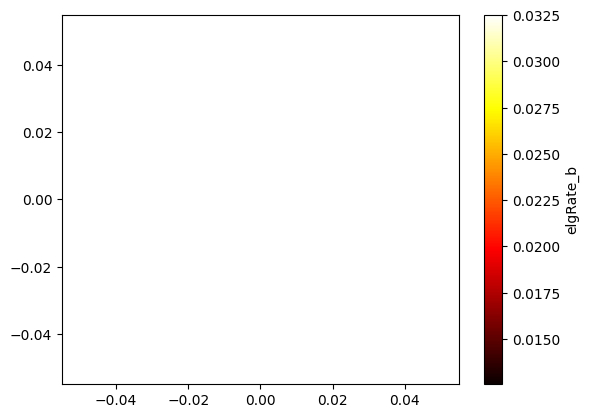

In [5]:
"""
plot elgRate etc. onto videos, e.g., col_name = "Lb" "division_time""elgRate_b"
outliers >3sigma not included
mean_solidity not used as filter anymore, as solidity<=0.7 excluded already when fitting for elgRate
----input----
Contour analysed by TrackMate:
-tracks.csv []
-elg_ellipse.csv  [cell_ID, generation, time_start, mean_solidity, Lb, Ld, elgRate, elgRate_start, division_time]

Contour analysed by opencv:
-tracks-cv2.csv
-elg-cv2.csv [cell_ID, generation, time_start, mean_solidity, Lb, Ld, 
elgRate_b, elgRate_start_b, elgRate_e, elgRate_start_e, division_time]


----output----
tif image stack , elgRate plot onto each cell (-BG) as color dots
if needed, plot colorbar as a separate image

"""
pathDict = {'075': ['241219-075-ana/00738', 
                    '250116-075-ana/00814', 
                    '250117-075-2-ana/00823'],
            '150': ['240228-150-1-ana/00324',
                   '250107-150-ana/00778', 
                   '250108-150-ana/00788',
                   '250606-150-ana/00909'],
            '300': ['241220-3-ana/00753', 
                   '250102-3-ana/00766',
                   '250103-3-2-ana/00772-2'],
            '600': ['241218-6-ana/00734-2',
                   '250115-6-1-ana/00798-2']
}


rplcpath ='ForPub/150-LBLMagar/250718-150-ana/00957'
head, rplcIdx = os.path.split(rplcpath)
plotpath = rplcpath + '/plot-videos-cv2'
if not os.path.exists(plotpath):
    os.makedirs(plotpath)

tracksName = rplcIdx + "-tracks-cv2.csv" 
trackspath = os.path.join(rplcpath, tracksName)
elgName = rplcIdx + "-elg-cv2_250628.csv"
elgpath = os.path.join(rplcpath, elgName)

# data plotted onto video
col_name = "elgRate_b" # "division_time" "elgRate_b"  "Lb"


nbgName = rplcIdx + '-BG.tif'
fpath = os.path.join(rplcpath, nbgName)
outName = rplcIdx + col_name + '.tif'
outpath = os.path.join(plotpath, outName)
colorbarName = rplcIdx + col_name + '-colorbar.svg'
coloarbarpath = os.path.join(plotpath, colorbarName)

tracks_df = pd.read_csv(trackspath, header=0, 
                       usecols=["cell_ID", "frame", "x", "y"])
# cell_ids = tracks_df["cell_ID"].unique().tolist()
elg_df = pd.read_csv(elgpath, header=0)
# [cell_ID,generation,time_start,mean_solidity,mean_width,Lb,Ld,elgRate_b,division_time]

tracks_df["frame"] = tracks_df["frame"].astype(int)


# remove outliers in target data column
elg_mean = elg_df[col_name].mean()
std_dev = elg_df[col_name].std()
z_scores = np.abs((elg_df[col_name] - elg_mean)) / std_dev
elg_filtered = elg_df[np.abs(z_scores) < 5]
cell_ids = elg_filtered["cell_ID"].unique().tolist()

#     # filter by mean_solidity > 0.8 (remove long curved cells)
#     elg_filtered1 = elg_df[elg_df["mean_solidity"] > 0.7]  # 0 for not filtered for now


# Set up the colormap
colormap = matplotlib.colormaps.get_cmap('hot')
# norm = plt.Normalize(vmin=min(elg_filtered2[col_name]), vmax=max(elg_filtered2[col_name]))  # Normalize based on min/max values in data
norm = plt.Normalize(vmin=(elg_mean-3*std_dev), vmax=(elg_mean+3*std_dev))  # Normalize based on min/max values in data

# ###generate a dumb plot to get the colorbar
fig, ax = plt.subplots()
sc = ax.scatter([], [], c=[], cmap=colormap, norm=norm)  # Dummy scatter for colorbar
plt.colorbar(sc, ax=ax, label=col_name)  # Add colorbar based on colormap
plt.savefig(coloarbarpath)

frames = []
frames_processed = []
ret,frames = cv2.imreadmulti(mats=frames, filename=fpath, 
#                               start=0, count=100,                              
                               flags=cv2.IMREAD_COLOR)

for frame_index, frame in enumerate(frames):
    # Convert the frame to RGB format if it's grayscale (required by PIL)
    if len(frame.shape) == 2:  # grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    # cell_ids is filtered and only from elg_filtered2    
    for cell_id in sorted(cell_ids):
        traj = tracks_df.loc[tracks_df["cell_ID"] == cell_id, ["cell_ID", "frame", "x", "y"]].to_numpy()
        fIdxS = traj[0, 1]  # traj starting frm
        fIdxE = traj[-1, 1]  # traj starting frm
        ###testpoint 
        # if frame_index == 50 and cell_id == 5:
        #     print(traj[:5, :], fIdxS, fIdxE)

        if fIdxS <= frame_index <= fIdxE:            
            elgValue = elg_df.loc[elg_df["cell_ID"]  == cell_id, col_name].iloc[0]  
            traj_point = traj[traj[:,1] == frame_index]
            
            if traj_point.shape[0] == 0:  # Check if empty
                print(f"Warning: No trajectory point found for cell {cell_id} at frame {frame_index}")
                continue  # Skip this cell_id
                
            color = colormap(norm(elgValue))
            cl = tuple((np.array(color[:3]) * 255))
            ###testpoint 
            if frame_index == 50:
                print(cell_id, elgValue, traj_point)  
            # Draw the current position as a circle
            cv2.circle(frame, (int(traj_point[0, 2]), int(traj_point[0, 3])), 7, cl, -1)
            # cv2.circle(frame, (int(elgRT[0, 2]), int(elgRT[0, 3])), 7, cl, -1)

    frames_processed.append(Image.fromarray(frame))

# Save the processed frames as a TIFF stack
frames_processed[0].save(outpath, save_all=True, append_images=frames_processed[1:], compression="tiff_deflate")



In [ ]:
"""
color cells based on their orientations

1. find orientation of each contour cv2.minAreaRect() or cv2.fitEllipse()
2. color contours based on orientation

---input---
"-BG_Simple Segmentation.tiff"

---output---
"plot-videos-cv2\-orientation.tif"

"""
pathDict = {'075': ['241219-075-ana/00738', 
                    '250116-075-ana/00814', 
                    '250117-075-2-ana/00823'],
            '150': ['250107-150-1-ana/00778', 
                   '250108-150-ana/00788'],
            '300': ['241220-3-ana/00753', 
                   '250102-3-ana/00766',
                   '250103-3-2-ana/00772-2'],
            '600': ['241218-6-ana/00734-2',
                   '250115-6-1-ana/00798-2']
}
for i in range(4):
    c = list(pathDict.keys())[i]  # '075'
    paths = pathDict[c]  # path list
    
    for j in range(len(paths)):
        path = paths[j]
        rplcpath = os.path.join('ForPub', f"{c}-LBLMagar", path)

#         rplcpath ='ForPub/300-LBLMagar/241220-3-ana/00753'
        head, rplcIdx = os.path.split(rplcpath)
        plotpath = rplcpath + '/plot-videos-cv2'
        segName = rplcIdx + '-BG_Simple Segmentation.tiff'
        segpath = os.path.join(rplcpath, segName)
        outName = rplcIdx + '-orientation.tif'
        outpath = os.path.join(plotpath, outName)

        frames = []
        frames_processed = []
        ret,frames = cv2.imreadmulti(mats=frames, filename=segpath, flags=cv2.IMREAD_GRAYSCALE)
        for frame_index, binary in enumerate(frames):
            contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            color_img = np.zeros((binary.shape[0], binary.shape[1], 3), dtype=np.uint8)

            for cnt in contours:
                # Skip tiny contours
                if cv2.contourArea(cnt) < 10:
                    continue

                # Option 1: Bounding Box Orientation !!!often mix by +90
        #         rect = cv2.minAreaRect(cnt)
        #         angle = rect[2]  # In degrees
        #         if angle < -45:
        #             angle += 90  # Normalize to [0, 90)

                # Option 2: Ellipse Fitting Orientation
                if len(cnt) >= 5:
                    ellipse = cv2.fitEllipse(cnt)
                    angle = ellipse[2]  # Ellipse orientation (major axis)

                angle = angle % 180
                # Map angle to hue (HSV: 0–179 in OpenCV)
                hue = int(angle / 180.0 * 179)
                color = cv2.cvtColor(np.uint8([[[hue, 255, 255]]]), cv2.COLOR_HSV2BGR)[0, 0]

                # Draw filled contour with the color
                cv2.drawContours(color_img, [cnt], -1, color.tolist(), thickness=cv2.FILLED)

            frames_processed.append(Image.fromarray(color_img))

        # Save the processed frames as a TIFF stack
        frames_processed[0].save(outpath, save_all=True, append_images=frames_processed[1:], compression="tiff_deflate")

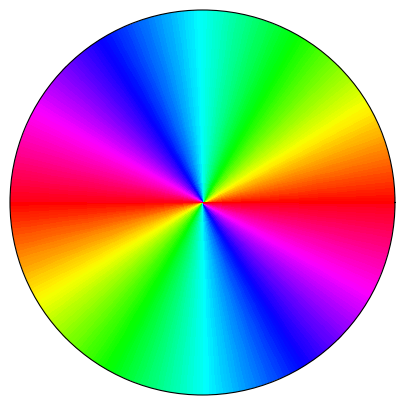

In [22]:

plotpath = 'ForPub/ForPub-plot/'
# Parameters
radius = 1.0
n_angles = 360
n_radii = 10

# Create polar coordinates
theta = np.linspace(0, 2*np.pi, n_angles)  # 0 to 360 degrees
r = np.linspace(0, radius, n_radii)
T, R = np.meshgrid(theta, r)

# Nematic symmetry: fold θ onto [0, π)
theta_nematic = T % np.pi  # Now range is [0, π)
# Convert to degrees
angle_deg = np.degrees(theta_nematic)

# Normalize to colormap range
colors = angle_deg / 180.0

# Create figure
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5, 5))
c = ax.pcolormesh(T, R, colors, cmap='hsv', shading='auto')

# Hide ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([])
# ax.set_title("Circular Orientation Colormap", pad=20)

# Save as SVG (vector editable)
plt.savefig(os.path.join(plotpath, "circular_colormap_nematic0.svg"))
plt.show()

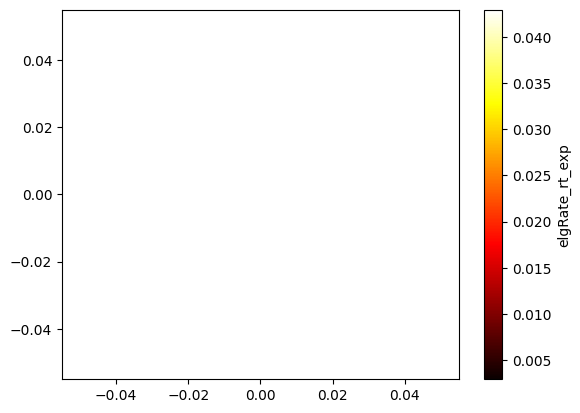

In [43]:
""" 
plot realtime elongation rate to videos (j+5 calculated from [j:j+5])

----input----
Contour analysed by opencv:
-tracks-cv2-elg.csv
["cell_ID", "cell_parent_ID", "cell_daughter1_ID", "cell_daughter2_ID", "lineage", "generation", "tm_spot_ID", "frame", 
 "x", "y", "area", "solidity", "rect_length", "rect_aspect_ratio", "rect_angle", "ellipse_long_axis", "ellipse_theta",
 "elgRate_rt_linear", "elgRate_rt_exp"]


----output----
tif image stack , elgRate plot onto each cell (-BG) as color dots
if needed, plot colorbar as a separate image
"""
# rplcpath ='ForPub/075-LBLMagar/00823'
head, rplcIdx = os.path.split(rplcpath)
plotpath = rplcpath + '/plot-videos-cv2'
if not os.path.exists(plotpath):
    os.makedirs(plotpath)

tracksName = rplcIdx + "-tracks-cv2-elgrt.csv" 
trackspath = os.path.join(rplcpath, tracksName)

# data plotted onto video
col_name = "elgRate_rt_exp"  
Filter = True


nbgName = rplcIdx + '-BG.tif'
fpath = os.path.join(rplcpath, nbgName)
outName = rplcIdx + col_name + '.tif'
outpath = os.path.join(plotpath, outName)
colorbarName = rplcIdx + col_name + '-colorbar.svg'
coloarbarpath = os.path.join(plotpath, colorbarName)

tracks_df = pd.read_csv(trackspath, header=0)
tracks_df["frame"] = tracks_df["frame"].astype(int)
# cell_ids = tracks_df["cell_ID"].unique().tolist()

# statistics of elg
elg_mean = tracks_df[col_name].mean(skipna=True)
std_dev = tracks_df[col_name].std(skipna=True)

#forward and backward fill f1, 2 and f[-1] f[-2]
tracks_df = tracks_df.sort_values(by=["cell_ID", "frame"])
tracks_df[col_name] = tracks_df.groupby("cell_ID")[col_name].transform(lambda x: x.ffill().bfill())
tracks_df["z_score"] = np.abs((tracks_df[col_name] - elg_mean) / std_dev)


# Set up the colormap
colormap = matplotlib.colormaps.get_cmap('hot')
norm = plt.Normalize(vmin=(elg_mean-3*std_dev), vmax=(elg_mean+3*std_dev))  # Normalize based on min/max values in data
# ###generate a dumb plot to get the colorbar
fig, ax = plt.subplots()
sc = ax.scatter([], [], c=[], cmap=colormap, norm=norm)  # Dummy scatter for colorbar
plt.colorbar(sc, ax=ax, label=col_name)  # Add colorbar based on colormap
plt.savefig(coloarbarpath)

frames = []
frames_processed = []
ret,frames = cv2.imreadmulti(mats=frames, filename=fpath, 
#                               start=0, count=100,                              
                               flags=cv2.IMREAD_COLOR)

for frame_index, frame in enumerate(frames):
    # Convert the frame to RGB format if it's grayscale (required by PIL)
    if len(frame.shape) == 2:  # grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)

    frame_data = tracks_df[tracks_df["frame"] == frame_index] # filter data on current frame
    for _, row in frame_data.iterrows():
        x, y, elg, z_score, solidity = (row["x"], row["y"], row[col_name], row["z_score"], row["solidity"])
        if Filter:
            if z_score >3 or solidity < 0.7:
                elg = None

        if elg is not None and not np.isnan(elg):
            color = colormap(norm(elg))
            cl = tuple((np.array(color[:3]) * 255))
            # cl = tuple((np.array(color[:3]) * 255).astype(int))
            cv2.circle(frame, (int(x), int(y)), 7, cl, -1) 
        # else:
        #     continue
            
        # if frame_index == 50:
        #     print(cell_id, elgValue, traj_point)  
    frames_processed.append(Image.fromarray(frame))

# Save the processed frames as a TIFF stack
frames_processed[0].save(outpath, save_all=True, append_images=frames_processed[1:], compression="tiff_deflate")        


In [38]:
print(frame_index, elg, cl)

124 nan (np.float64(0.0), np.float64(0.0), np.float64(0.0))


00392-3/00392-3-elgRTDic.pkl


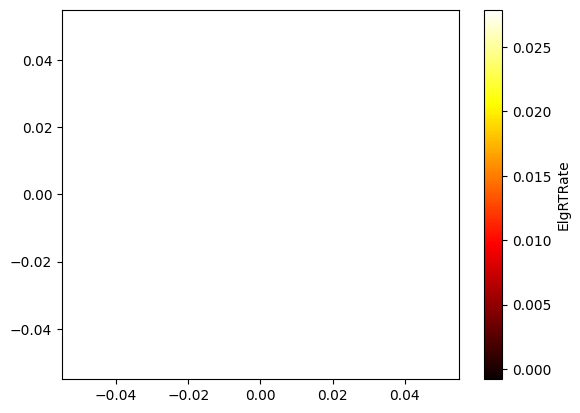

In [4]:
""" 
plot realtime elongation rate to videos (j+5 calculated from [j:j+5])
skip 0
generate colormap with elongation-fitted-e ± 5 sigma
elgRateRT not filtered, outliers will show at the extreme color

Input: 
    elgDic.pkl {TrajIdx: # fIdx, cellIdx, cntx, cnty, length, elgRateRT [um/min], elgRateN, #G(g0)}
    elongation-fitted-e.txt, for kick out outliers
Output:
    elrateRT.tif, elrateRT-colorbar
"""

# exppath = 'glass-LBLMagar-010/240618-010LBLMagar-ana/' # 240613, 240618
# exppath = 'glass-LBLMagar-015/240228-agar-GF-ana/'  #240228 240307
# exppath = 'LB-glass-coverslip/240229-glass-GF-ana/'
# exppath = 'glass-LBLMagar/Elongations/240307/'  #   240307 231006-60x

rplcpath= '00392-3/'
rplcIdx = '00392-3'

dataDicName = rplcIdx + '-dataDic.pkl'
trajDicName = rplcIdx + '-trajDic.pkl'
elgDicName = rplcIdx + '-elgRTDic.pkl'
cnpath = os.path.join(rplcpath, dataDicName)
trajpath = os.path.join(rplcpath, trajDicName)
elgpath = os.path.join(rplcpath, elgDicName)

nbgName = rplcIdx + '-BG.tif'
outName = rplcIdx + '-elgRateRT.tif'
plotName = rplcIdx + '-elgRateRT-colorbar.svg'
plotpath = os.path.join(rplcpath, plotName)
# read in data
print(elgpath)
with open(elgpath, 'rb') as fe:
    elgDic = pickle.load(fe)    # TrajIdx: # fIdx, cellIdx, cntx, cnty, length, elgRateRT [um/min], elgRateN, #G(g0)
with open(trajpath, 'rb') as f:
    trajDic = pickle.load(f)
# for filtering outlier read in fitted-e
elg = np.loadtxt(os.path.join(rplcpath, 'elongation-fitted-e.txt'))
# trajIdx, 1L_b[um], 2elgRate(F) [um/min], 3#G(g0), 4stTime[min]
elg_mean = np.mean(elg[:, 2])
std_dev = np.std(elg[:, 2])
z_scores = (elg[:, 2] - elg_mean) / std_dev
elg_filtered = elg[np.abs(z_scores) < 5]   

# Set up the colormap with elg_filtered
colormap = matplotlib.colormaps.get_cmap('hot')
norm = plt.Normalize(vmin=min(elg_filtered[:, 2]), vmax=max(elg_filtered[:, 2]))  # Normalize based on min/max values in data
###generate a dumb plot to get the colorbar
fig, ax = plt.subplots()
sc = ax.scatter([], [], c=[], cmap=colormap, norm=norm)  # Dummy scatter for colorbar
plt.colorbar(sc, ax=ax, label='ElgRTRate')  # Add colorbar based on colormap
plt.savefig(plotpath)

fpath = os.path.join(rplcpath, nbgName)
outpath = os.path.join(rplcpath, outName)
frames = []
frames_processed = []
ret,frames = cv2.imreadmulti(mats=frames, filename=fpath, 
#                               start=0,
#                               count=100,                              
                               flags=cv2.IMREAD_COLOR)

for frame_index, frame in enumerate(frames):
    # Convert the frame to RGB format if it's grayscale (required by PIL)
    if len(frame.shape) == 2:  # grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
  
#TODO: use only elgDic
    for trajIdx, elgTrajData in elgDic.items():
        fIdxS = elgTrajData[0, 0]  # traj starting frm
        fIdxE = elgTrajData[-1, 0]  # traj starting frm
        # TrajIdx: # fIdx, cellIdx, cntx, cnty, length, elgRateRT [um/min], elgRateN, #G(g0)
        # if frame_index ==5:
        #     print(trajIdx, fIdxS)
        if fIdxS <= frame_index <= fIdxE:    
            elgData = elgTrajData[(elgTrajData == float(trajIdx))[:, 0]]

            traj_point = traj[(traj == float(frame_index))[:, 0]]
            # 0fIdx, 1cellIdx, 2cntx, 3cnty, 4rect0, 5rect1, 6area, 7aspect ratio(AR), 8length, 9angle
            elgRT = elgTrajData[(elgTrajData== float(frame_index))[:, 0]]
            # fIdx, 1cellIdx, 2cntx, 3cnty, 4length, 5elgRateRT [um/min], 6elgRateN, #G(g0)
            color = colormap(norm(elgRT[0, 6]))
            cl = tuple((np.array(color[:3]) * 255))
            # ###testpoint 
            # if frame_index == 50:
            #     print(trajIdx, norm(elgData[0, 2]), cl)  # elgData, traj_point
            # Draw the current position as a circle
            cv2.circle(frame, (int(elgRT[0, 2]), int(elgRT[0, 3])), 7, cl, -1)

    frames_processed.append(Image.fromarray(frame))

# Save the processed frames as a TIFF stack
frames_processed[0].save(outpath, save_all=True, append_images=frames_processed[1:], compression="tiff_deflate")


In [2]:
""" 
plotting elg rate or starting elg rate onto single video
Input: trajDic and elg.txt

"""

# rplcpath = 'glass-LBLMagar-010/240613-010LBLMagar-ana/00510-3'
rplcpath ='ForPub/300-LBLMagar/00766'

head, rplcIdx = os.path.split(rplcpath) 
print(rplcIdx)

dataDicName = rplcIdx + '-dataDic.pkl'
plotName = rplcIdx + '-elrate-colorbar.svg'
# divName = rplcIdx + '-Div.txt'
# rawName = rplcIdx + '.tif'
nbgName = rplcIdx + '-BG.tif'
outName = rplcIdx + '-elgRateF.tif'
segName = rplcIdx + '-BG_Simple Segmentation.tiff' 
trajDicName = rplcIdx + '-trajDic.pkl'
cnpath = os.path.join(rplcpath, dataDicName)
plotpath = os.path.join(rplcpath, plotName)
trajpath = os.path.join(rplcpath, trajDicName)

# read in data
with open(cnpath, 'rb') as ff:
    dataDic = pickle.load(ff)    
with open(trajpath, 'rb') as f:
    trajDic = pickle.load(f)
elg = np.loadtxt(os.path.join(rplcpath, 'elongation-rate.txt'))
# elg = np.loadtxt(os.path.join(rplcpath, 'elongation-fitted-e.txt'))
# trajIdx, 1L_b[um], 2elgRate [/min], 3#G(g0), 4stTime[min], 5endTime[min], 6L_d[um], 7elgRateFresh [/min]

# filter elg based on elgRate
elg_mean = np.mean(elg[:, 2])
std_dev = np.std(elg[:, 2])
z_scores = (elg[:, 2] - elg_mean) / std_dev
elg_filtered = elg[np.abs(z_scores) < 3]

# Set up the colormap
colormap = matplotlib.colormaps.get_cmap('hot')
norm = plt.Normalize(vmin=min(elg_filtered[:, 2]), vmax=max(elg_filtered[:, 2]))  # Normalize based on min/max values in data
# ###generate a dumb plot to get the colorbar
# fig, ax = plt.subplots()
# sc = ax.scatter([], [], c=[], cmap=colormap, norm=norm)  # Dummy scatter for colorbar
# plt.colorbar(sc, ax=ax, label='ElgRate')  # Add colorbar based on colormap
# plt.savefig(plotpath)


fpath = os.path.join(rplcpath, segName)
outpath = os.path.join(rplcpath, outName)
frames = []
frames_processed = []
ret,frames = cv2.imreadmulti(mats=frames, filename=fpath, 
#                               start=0,
#                               count=100,                              
                               flags=cv2.IMREAD_COLOR)

for frame_index, frame in enumerate(frames):
    # Convert the frame to RGB format if it's grayscale (required by PIL)
    if len(frame.shape) == 2:  # grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)

    for trajIdx, traj in trajDic.items():
    # for trajIdx in trajDic.keys():
    #     traj = trajDic[trajIdx]
        fIdxS = traj[0, 0]  # traj starting frm
        fIdxE = traj[-1, 0]  # traj starting frm
        # ### testpoint
        # if frame_index ==5:
        #     print(trajIdx, fIdxS)
        if fIdxS <= frame_index: 
            elgData = elg_filtered[(elg_filtered == float(trajIdx))[:, 0]]
            # trajIdx, 1L_b[um], 2elgRate [um/min], 3#G(g0), 4stTime[min]
            # ###testpoint 
            # if frame_index == 5:
            #     print(trajIdx, elgData)
            if elgData.any() and frame_index <= fIdxE:
                traj_point = traj[(traj == float(frame_index))[:, 0]]
                # 0fIdx, 1cellIdx, 2cntx, 3cnty, 4rect0, 5rect1, 6area, 7aspect ratio(AR), 8length, 9angle
                color = colormap(norm(elgData[0, 2]))
                cl = tuple((np.array(color[:3]) * 255))
                ###testpoint 
                if frame_index == 50:
                    print(trajIdx, norm(elgData[0, 2]), cl)  # elgData, traj_point
                # Draw the current position as a circle
                cv2.circle(frame, (int(traj_point[0, 2]), int(traj_point[0, 3])), 7, cl, -1)
    # ###testpoint 
    # if frame_index == 50:
    #     cv2.circle(frame, (20, 20), 7, (0,0,255), -1)
    #     plt.imshow(frame)
    # Append the processed frame to the list
    frames_processed.append(Image.fromarray(frame))

# Save the processed frames as a TIFF stack
frames_processed[0].save(outpath, save_all=True, append_images=frames_processed[1:], compression="tiff_deflate")


00766
6 0.44897959183673464 (np.float64(255.0), np.float64(54.875155202872755), np.float64(0.0))
7 0.5428571428571428 (np.float64(255.0), np.float64(117.87505282803916), np.float64(0.0))
8 0.5142857142857142 (np.float64(255.0), np.float64(99.50008268736563), np.float64(0.0))
9 0.32653061224489793 (np.float64(228.49837441211355), np.float64(0.0), np.float64(0.0))
10 0.46122448979591824 (np.float64(255.0), np.float64(65.37513814040052), np.float64(0.0))
11 0.4816326530612244 (np.float64(255.0), np.float64(78.50011681231018), np.float64(0.0))
12 0.4040816326530612 (np.float64(255.0), np.float64(26.000202124671542), np.float64(0.0))
13 0.47755102040816316 (np.float64(255.0), np.float64(75.87512107792821), np.float64(0.0))


In [30]:
test[0:4, 0]

array([0.573, 0.057, 0.742, 0.421])